In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
%matplotlib  inline

# Adaptive Subunit Model

## $\dot{\alpha_i} = \frac{(1-\alpha_i)}{\tau_{slow}} - \alpha_iI_i(t)$

## $\tau_{fast} \dot{v_i} = -v_i + [\alpha_iv_i + I_i(t)]_+$

## $r(t) = \sum_{i=1}^{S}v_i(t)$

$\alpha_i = \text{adaptive variable of subunit, } \alpha_i \in [0,1]$

$\tau_{slow} = 10 \text{ sec}$

$I_i = \text{input to subunit } i$

$v_i = \text{spike rate of subunit } i$

$\tau_{fast} = 0.1  \text{ sec}$

$r = \text{spike rate of a simple cell}$

$S=\text{# of frames in a sequence}$

In [2]:
###Stimuli
dt = 0.01
T = 30
tt = np.arange(0,T,dt)

S = np.arange(0,4,1)
L = 15
marks = []
for ll in range(0,L):
    marks = np.append(marks,S[:-1])

temp = np.append(marks,S[-1])
marks = np.append(temp,marks)

dur = 0.2
ratio = int(dur/dt)
stimuli = []
for ii in range(0,len(marks)):
    stimuli = np.append(stimuli,marks[ii]*np.ones(ratio))

stimuli = stimuli + 1
    
k = len(tt)-len(stimuli)
if k < 0:
    stimuli = stimuli[:len(tt)]
else:
    stimuli = np.append(stimuli,np.zeros(k))

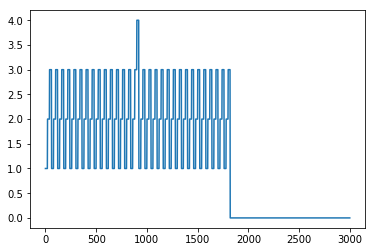

In [3]:
plt.plot(stimuli)

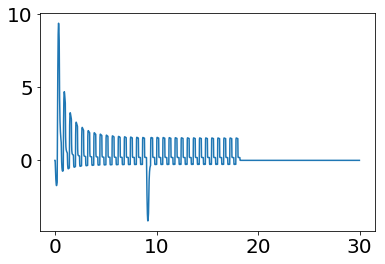

In [29]:
###adpative subunits
subu = len(S)
xs = np.zeros((subu,len(tt)))
vs = np.zeros((subu,len(tt)))
xs[:,0] = 1
vs[:,0] = 0
r = np.zeros(len(tt))
### w/ inhibitory feedforward
K = np.random.randn(subu)

A = 1
tauS = 10
tauF = 0.01

for t in range(0,len(tt)-1):
    I = np.zeros(subu)
    if int(stimuli[t]) >0: 
        I[int(stimuli[t])-1] = A
    xs[:,t+1] = xs[:,t] + ((1-xs[:,t])/tauS - np.multiply(xs[:,t],I)) *dt
    vs[:,t+1] = vs[:,t] + (-vs[:,t] + np.multiply(xs[:,t],vs[:,t]) + I)/tauF *dt
    #vs[:,t] = np.multiply(xs[:,t],I)
    r[t+1] = np.dot(vs[:,t],K) #np.sum(vs[:,t])
    
plt.plot(tt,r)

# With Anti-Hebb network

In [5]:
#learning parameters
alpha = 10.  #0.05
beta = 0.01
gamma = 0.1
lamb = 1
p = 0.
q = 0.02
dt = .01  #10 ms as a bin!!
T = int(100/dt)
time = np.arange(0,T*dt,dt)

In [6]:
#subunits
Ns = 20  #neurons
subs = 10  #subunits per neuron
stimn = 10  #stimuli area
olap = 1-0.8  #squeezed/shared representation (0-1)
allsub = int(Ns*subs*olap)
nn = allsub  #total number of subunits

#parameters
A = 5
tauS = 10
tauF = 0.01


In [7]:
#connectivity
Qc = np.zeros((Ns,nn))  #connectivity for shared sub-units to neurons
W = np.zeros((Ns,Ns))  #neural layer with anti-Hebbian dynamics

for i in range(0,Ns):
    temp = np.random.randint(nn,size = subs)
    Qc[i,temp] = 1

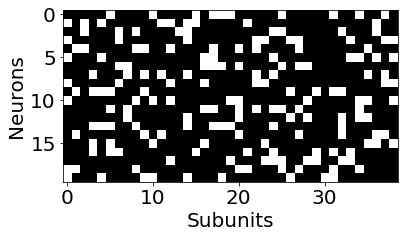

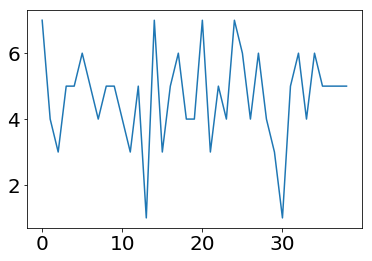

In [8]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
plt.imshow(Qc,cmap='gray',interpolation='none')  #adjacency matrix
plt.xlabel('Subunits')
plt.ylabel('Neurons')
plt.figure()
plt.plot(Qc.sum(0))  #convergance rate

In [9]:
###Stimuli
import numpy.matlib
#marks
fnum = 4
mark = np.arange(0,fnum,1) + 1
dur = 20
mark2 = np.repeat(mark,dur,axis=0)
L = 25
marks = np.matlib.repmat(np.expand_dims(mark2,axis=1),L,1)

#extended
wait = 1500
marks = np.concatenate((np.zeros((wait,1)),marks,marks+fnum,marks+fnum*2,marks+fnum*3),axis=0)
#marks = np.concatenate((marks,marks+fnum),axis=0)

#fixing length
if len(marks)<T:
    marks = np.concatenate((marks,np.zeros((T-len(marks),1))),axis=0)
elif len(marks)>T:
    marks = marks[0:T]

In [10]:
#filling patterns
II = np.zeros((T,nn))
patterns = np.random.randint(nn,size=(stimn,int(np.max(marks)+1)))
patterns = np.concatenate((np.zeros((stimn,1)),patterns),axis=1)
for ii in range(0,T):
    index = int(marks[ii])
    if index==0:
        II[ii,np.random.choice(nn,stimn)] = A  #relaxation under random input
    else:
        #II = [II[ii,j]=A for j in patterns[:,index]]
        indx = list(patterns[:,index].astype(int))
        II[ii,indx] = A

In [11]:
###subunits with anti-Hebb
#intialization
xs = np.zeros((nn,T))
vs = np.zeros((nn,T))
xs[:,0] = 1
vs[:,0] = 0
r = np.zeros((Ns,T))
th = np.zeros((Ns,T))
W = np.zeros((Ns,Ns))  #neural layer with anti-Hebbian dynamics

def NL_function(x,lamb):
    f = 1/(1+np.exp(-lamb*x))
    return f

#iteration
for t in range(0,T-1):
    xs[:,t+1] = xs[:,t] + ((1-xs[:,t])/tauS - np.multiply(xs[:,t],II[t,:])) *dt
    vs[:,t+1] = vs[:,t] + (-vs[:,t] + np.multiply(xs[:,t],vs[:,t]) + II[t,:])/tauF *dt
    #vs[:,t] = np.multiply(xs[:,t],I)
    #r[:,t+1] = vs[:,t] @ Qc.T
    
    r[:,t+1] = r[:,t] + dt*(NL_function(vs[:,t] @ Qc.T + W @ r[:,t] - th[:,t] , lamb) - r[:,t]/0.2)  #neural
    W = W + -alpha* (np.outer(r[:,t], r[:,t]) - p)  #anti-Hebb 
    #replace W with np.eye(Ns) for control withoutnanti-Hebbian
    np.fill_diagonal(W,np.zeros(W.shape[0]),int)
    W[W>0] = 0
    #Q = np.eye(nn)#Q + beta* y[tt,:] @ (x[tt,:]-Q)  #Hebb (not necassary)
    th[:,t+1] = 23 #th[:,t] + gamma* (r[:,t]-q)  #can be fixed at as an offset


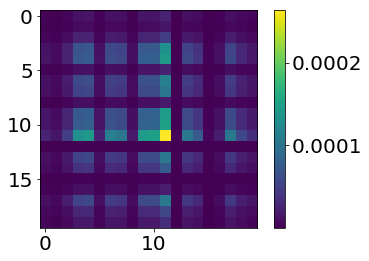

In [12]:
##checking with anti-Hebbian strength
plt.imshow(np.outer(r[:,t], r[:,t])-p)
plt.colorbar()

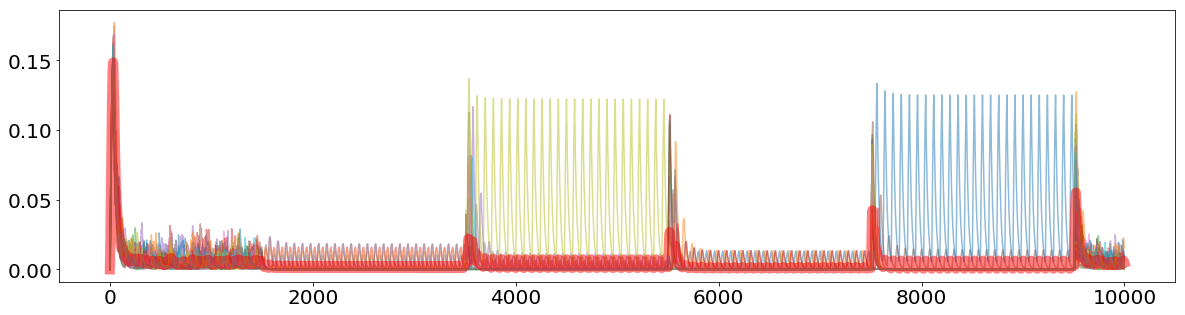

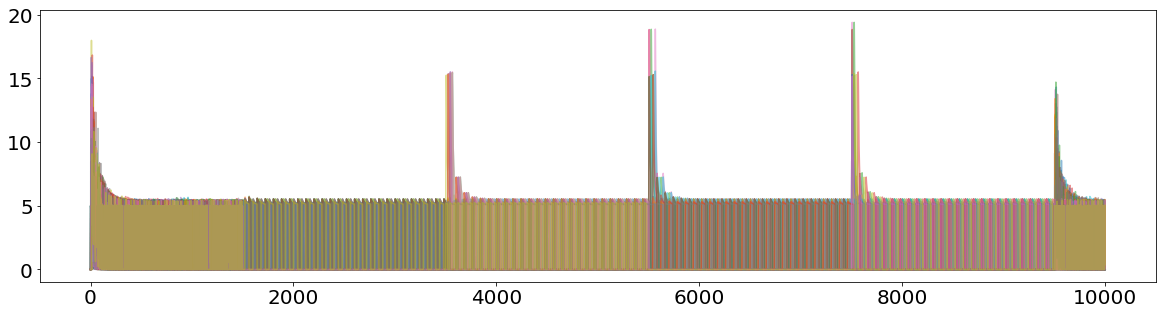

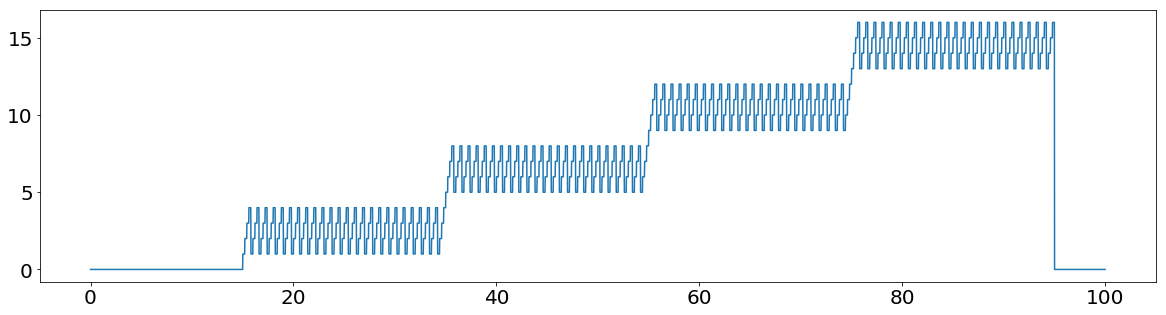

In [13]:
plt.figure(figsize=(20,5))
#plt.plot(vs.sum(0));
plt.plot(r.T,alpha=0.5);
plt.plot(r.mean(0),alpha=0.5,linewidth=10,color='red');
plt.figure(figsize=(20,5))
plt.plot(vs.T,alpha=0.5);

plt.figure(figsize=(20,5))
plt.plot(time,marks)

Text(0, 0.5, 'frame ID')

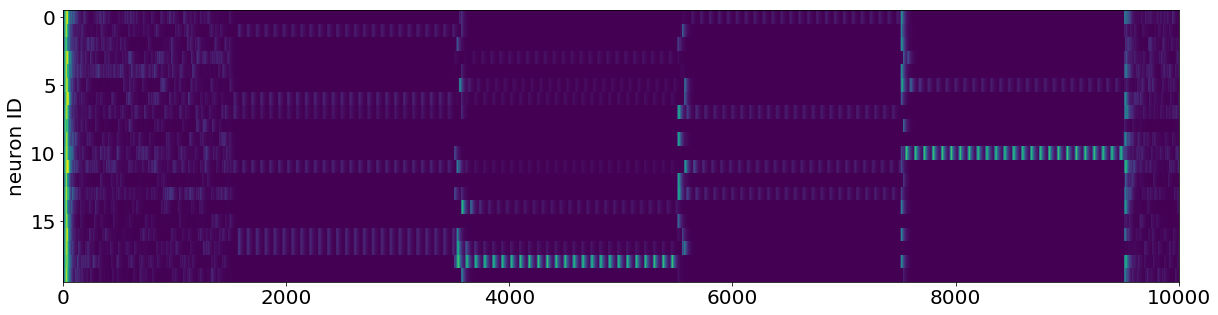

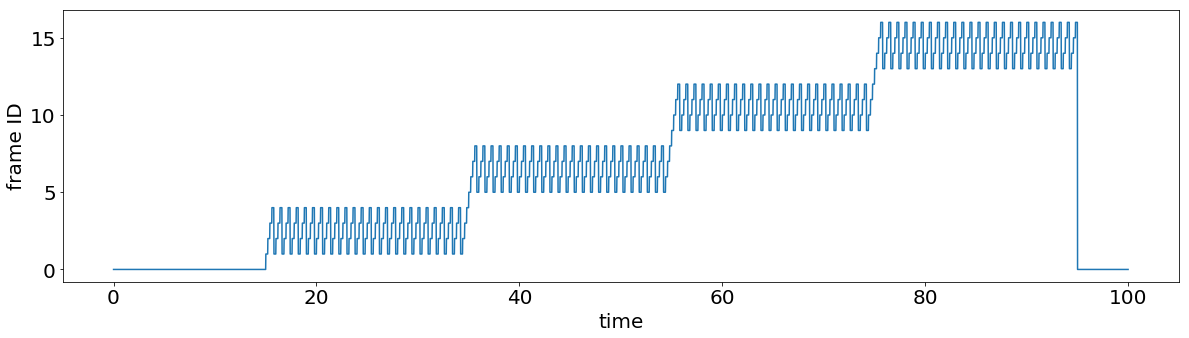

In [14]:
plt.figure(figsize=(20,5))
#plt.plot(vs.sum(0));
plt.imshow(r,interpolation='nearest', aspect='auto');
# plt.plot(r.mean(0),alpha=0.5,linewidth=10,color='red');
# plt.figure(figsize=(20,5))
# plt.plot(vs.T,alpha=0.5);
plt.ylabel('neuron ID')

# plt.figure(figsize=(20,5))
# plt.plot(time,marks)
plt.figure(figsize=(20,5))
plt.plot(time,marks)
plt.xlabel('time')
plt.ylabel('frame ID')

Text(0, 0.5, 'frame ID')

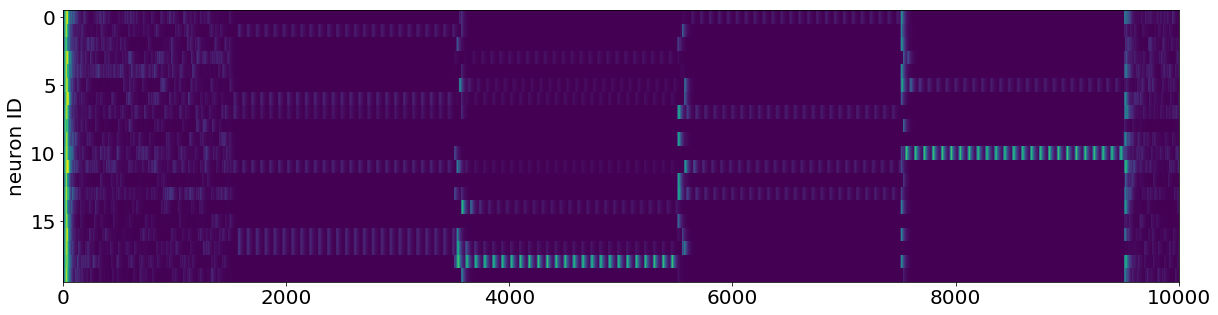

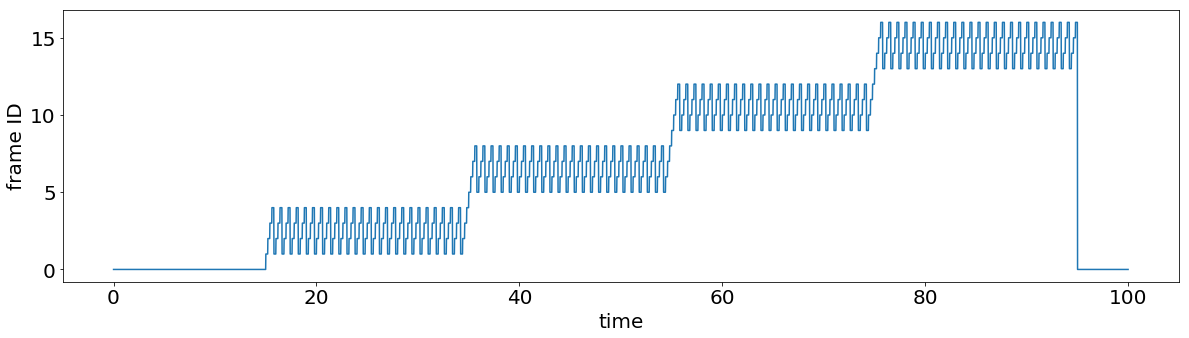

In [15]:
plt.figure(figsize=(20,5))
#plt.plot(vs.sum(0));
plt.imshow(r,interpolation='nearest', aspect='auto');
# plt.plot(r.mean(0),alpha=0.5,linewidth=10,color='red');
# plt.figure(figsize=(20,5))
# plt.plot(vs.T,alpha=0.5);
plt.ylabel('neuron ID')

# plt.figure(figsize=(20,5))
# plt.plot(time,marks)
plt.figure(figsize=(20,5))
plt.plot(time,marks)
plt.xlabel('time')
plt.ylabel('frame ID')

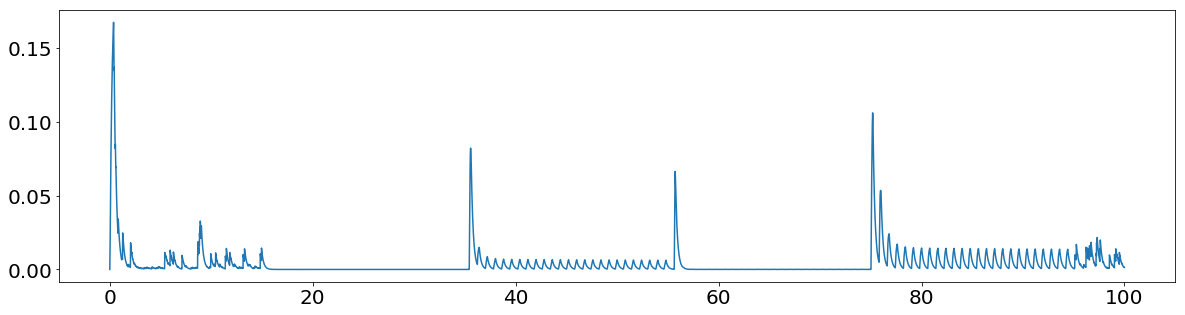

In [16]:
plt.figure(figsize=(20,5))
plt.plot(time,r[5,:])

# Local Anti-Hebbian Learning

# $\tau\frac{dy_j}{dt} = -y + \sigma(\sum_{i=1}^{n} A_{ij} x_i + \sum_{i=1}^{m} W_{ij} y_i - T_j)$


# $\sigma(u) = \frac{1}{1+e^{-\lambda u}}$


# $\Delta W_{ij} = -\alpha(y_i y_j - p)$

# $\Delta T_{j} = \gamma(y_j - q)$

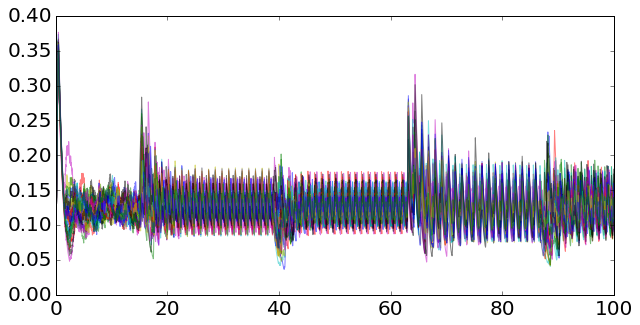

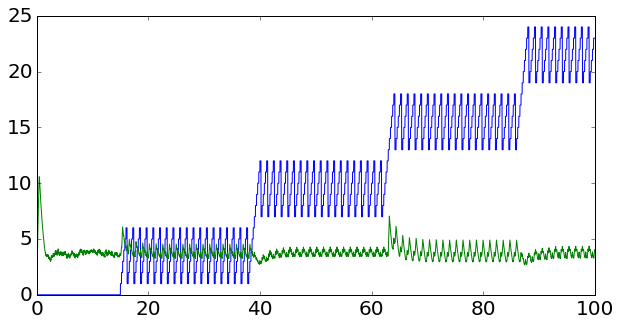

In [16]:
###Original draft (with Hebbian learning)

import numpy.matlib

#learning parameters
alpha = 0.5
beta = 0.01
gamma = 0.02
lamb = 2
p = 1/8
dt = .01
T = int(100/dt)
time = np.arange(0,T*dt,dt)

#neural network
nn = 30
W = np.random.rand(nn,nn)#np.zeros((nn,nn))#
Q = np.random.rand(nn,nn)
y = np.zeros((T,nn))
th = np.zeros((T,nn))
def NL_function(x,lamb):
    f = 1/(1+np.exp(-lamb*x))
    return f

### stimuli ###
#marks
fnum = 6
mark = np.arange(0,fnum,1) + 1
dur = 20
mark2 = np.repeat(mark,dur,axis=0)
L = 20
marks = np.matlib.repmat(np.expand_dims(mark2,axis=1),L,1)

#extended
wait = 1500
marks = np.concatenate((np.zeros((wait,1)),marks,marks+fnum,marks+fnum*2,marks+fnum*3),axis=0)
#marks = np.concatenate((marks,marks+fnum),axis=0)

#fixing length
if len(marks)<T:
    marks = np.concatenate((marks,np.zeros((T-len(marks),1))),axis=0)
elif len(marks)>T:
    marks = marks[0:T]

#filling patterns
x = np.zeros((T,nn))
patterns = np.random.randint(2,size=(nn,int(np.max(marks)+1)))
patterns = np.concatenate((np.zeros((nn,1)),patterns),axis=1)
for ii in range(0,T):
    index = int(marks[ii])
    if index==0:
        x[ii,:] = np.squeeze(np.random.randint(2,size=(nn,1)))  #relaxation under random input
    else:
        stimuli = patterns[:,index]  #sequence patterns
        x[ii,:] = stimuli

#dynamics
for tt in range(0,T-1):
    temp = y[tt,:] + dt*(NL_function(Q @ x[tt,:] + W @ y[tt,:] - th[tt,:] , lamb) - y[tt,:]/1)  #neural
    #temp[temp>=0.5] = 1
    #temp[temp<0.5] = 0
    y[tt+1,:] = temp
    W = W + -alpha* (np.outer(y[tt,:], y[tt,:]) - p**2)  #anti-Hebb
    np.fill_diagonal(W,np.zeros(W.shape[0]),int)
    W[W>0] = 0
    Q = Q + beta* y[tt,:] @ (x[tt,:]-Q)  #Hebb
    th[tt+1,:] = th[tt,:] + gamma* (y[tt,:]-p)  #threshold
     
#plot
plt.figure(figsize=(10,5))
plt.plot(time,y,alpha=0.5);
plt.figure(figsize=(10,5))
plt.plot(time,marks)
plt.hold(True)
plt.plot(time,y.sum(1))
#plt.figure(figsize=(10,10))
#plt.imshow(y[0:5000,:].T,interpolation='nearest', aspect='auto')